# Optical Digit Recognition
In this notebook, we will develop and compare some classifiers for recognizing digits from images. More specifically, we will develop Gaussian Naive Bayes classifier from scratch and compare it with other classifiers. Moreover, we will develop a simple Deep Neural Network and train it and compare its behaviour to the other machine learning models for this classification problem. The data comes from the US Postal Service (handwritten on postal envelopes and scannes and available in Kaggle) and contains the digits 0 to 9.  First, we import all the necessary libraries.

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


We will use two files, one containing train data and the other containing test data. The data of each file represents the contents of an array with the values of the array being space-separated. Each line corresponds for one digit - sample. The columns correspond to the features that describe the digits. Each digit is described by 257 values of with the first corresponds to the digit itself and the remaining 256 are the features that describe it in greyscale values. Each digit is represented in a 16x16 matrix consisting of 256 pixels.

In [2]:
N_train = 7291
N_test = 2007
n_features = 256
X_train = np.zeros((N_train, n_features),dtype = np.float64)
X_test = np.zeros((N_test, n_features), dtype = np.float64)
y_train = np.zeros(N_train, dtype=np.int8)
y_test = np.zeros(N_test, dtype=np.int8)

# For local execution

# with open("train.txt") as file:
#     lines = file.readlines()
#     for i, line in enumerate(lines):
#         line = line.split()
#         y_train[i] = int(float(line[0]))
#         X_train[i] = np.asarray(line[1:])

# with open("test.txt") as file:
#     lines = file.readlines()
#     for i, line in enumerate(lines):
#         line = line.split()
#         y_test[i]=int(float(line[0]))
#         X_test[i]=np.asarray(line[1:])
        
# For Kaggle Execution
    
with open("../input/odr-dataset/train.txt") as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        line = line.split()
        y_train[i] = int(float(line[0]))
        X_train[i] = np.asarray(line[1:])

with open("../input/odr-dataset/test.txt") as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        line = line.split()
        y_test[i]=int(float(line[0]))
        X_test[i]=np.asarray(line[1:])

Then we define some utility functions that will help us develop our classifier. 

In [3]:
def show_sample(X, index):
    '''Takes a dataset (e.g. X_train) and imshows the digit at the corresponding index
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        index (int): index of digit to show
    '''
    plt.imshow(X[index].reshape(16,16), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def plot_digits_samples(X, y):
    '''Takes a dataset and selects one example from each label and plots it in subplots
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
    '''
    fig = plt.figure(figsize=(18,8))
    classes = list(np.unique(y))
    for i in range(len(classes)):
        el_imgs = np.where(y == classes[i])[0]
        random_index = random.choice(el_imgs)
        # random_img = X[random_index].reshape(16,16)
        fig.add_subplot(2,5, classes[i]+1)
        plt.axis('off')
        show_sample(X, random_index)
        plt.title("index: "+str(random_index))

        
def digit_mean_at_pixel(X, y, digit, pixel=(10, 10)):
    '''Calculates the mean for all instances of a specific digit at a pixel location
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
        digit (int): The digit we need to select
        pixels (tuple of ints): The pixels we need to select.
    Returns:
        (float): The mean value of the digits for the specified pixels
    '''
    indices = np.where(y==digit)
    digit_imgs = X[indices]
    reshaped_imgs = np.reshape(digit_imgs, (digit_imgs.shape[0], 16, 16))
    pixel_imgs = reshaped_imgs[:,pixel[0],pixel[1]]
    return np.mean(pixel_imgs)

def digit_variance_at_pixel(X, y, digit, pixel=(10, 10)):
    '''Calculates the variance for all instances of a specific digit at a pixel location
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
        digit (int): The digit we need to select
        pixels (tuple of ints): The pixels we need to select
    Returns:
        (float): The variance value of the digits for the specified pixels
    '''
    indices = np.where(y==digit)
    digit_imgs = X[indices]
    reshaped_imgs = np.reshape(digit_imgs, (digit_imgs.shape[0], 16, 16))
    pixel_imgs = reshaped_imgs[:,pixel[0],pixel[1]]
    return np.var(pixel_imgs)

def digit_mean(X, y, digit):
    '''Calculates the mean for all instances of a specific digit
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
        digit (int): The digit we need to select
    Returns:
        (np.ndarray): The mean value of the digits for every pixel
    '''
    indices = np.where(y==digit)
    digit_imgs = X[indices]
    return np.mean(digit_imgs, axis=0)

def digit_variance(X, y, digit):
    '''Calculates the variance for all instances of a specific digit
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
        digit (int): The digit we need to select
    Returns:
        (np.ndarray): The variance value of the digits for every pixel
    '''
    indices = np.where(y==digit)
    digit_imgs = X[indices]
    return np.var(digit_imgs, axis=0)

def calculate_priors(X, y):
    """Return the a-priori probabilities for every class
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
    Returns:
        (np.ndarray): (n_classes) Prior probabilities for every class
    """
    return np.bincount(y)/len(y)

pdf = lambda x,m,s: np.sqrt(1/(2*np.pi*(s+10**(-7)))) * np.exp(-((x-m)**2)/(2*s+10**(-7)))

Next we randomly pick a digit from every class and plot it in a figure with subplots.

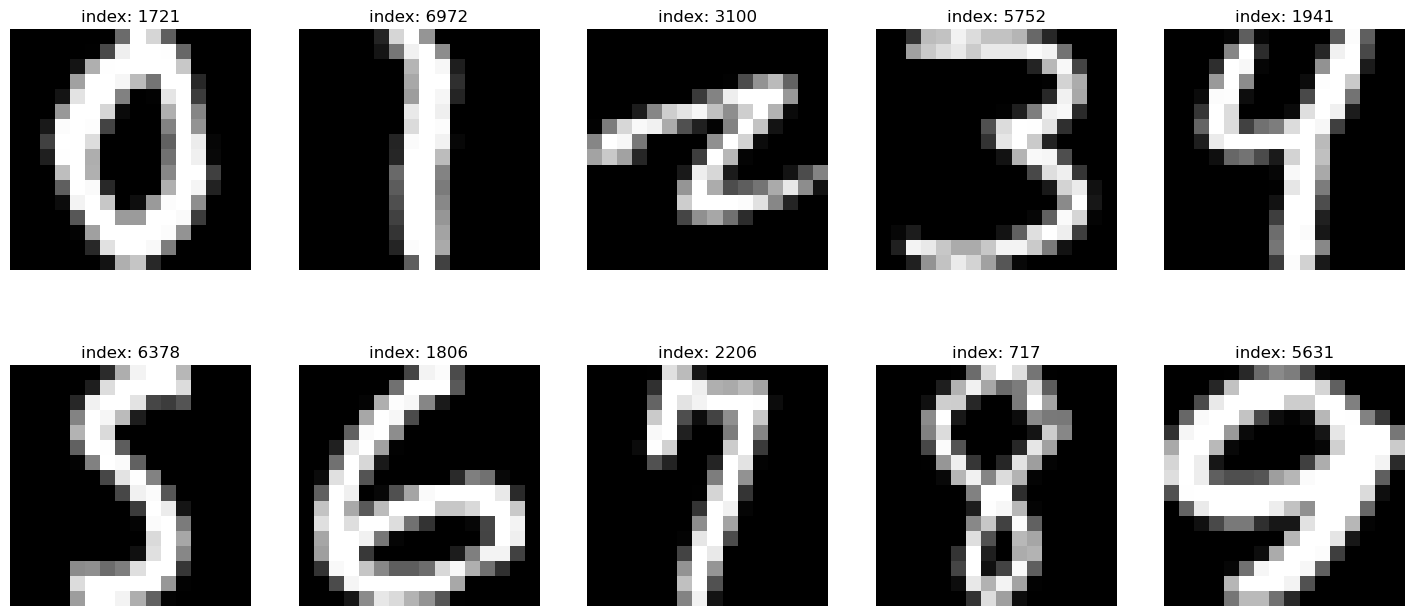

In [4]:
plot_digits_samples(X_train, y_train)

Moreover we have developed functions in order to develop image statistics like the mean value and the variance of a specific pixel or of a specific digit, as shown next.

In [5]:
mean_0 = digit_mean_at_pixel(X_train, y_train, 0, pixel=(10,10))
print("The mean value of pixel (10,10) of 0's in the train dataset is: {:.5f}".format(mean_0))
var_0 = digit_variance_at_pixel(X_train, y_train, 0, pixel=(10, 10))
print("The variance of pixel (10,10) of 0's in the train dataset is: {:.5f}".format(var_0))

The mean value of pixel (10,10) of 0's in the train dataset is: -0.50419
The variance of pixel (10,10) of 0's in the train dataset is: 0.52452


We compute the mean value images of all digits and plot them.

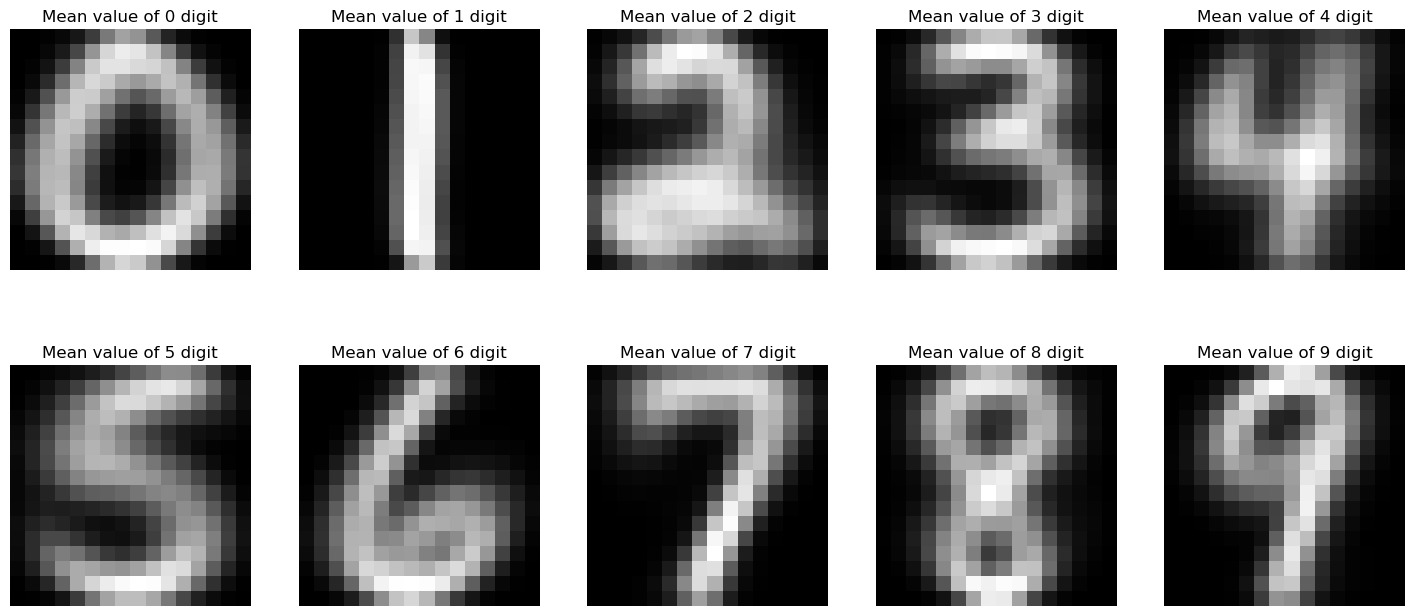

In [6]:
mean_digits = np.zeros((10,n_features), dtype=np.float64)
fig = plt.figure(figsize=(18,8))
for i in range(0,10):
    mean_digits[i] = digit_mean(X_train, y_train, i)
    fig.add_subplot(2,5,i+1)
    plt.imshow(mean_digits[i].reshape(16,16), cmap="gray")
    plt.axis('off')
    plt.title("Mean value of {} digit".format(i))

We compute the variance images of all digits and plot them.

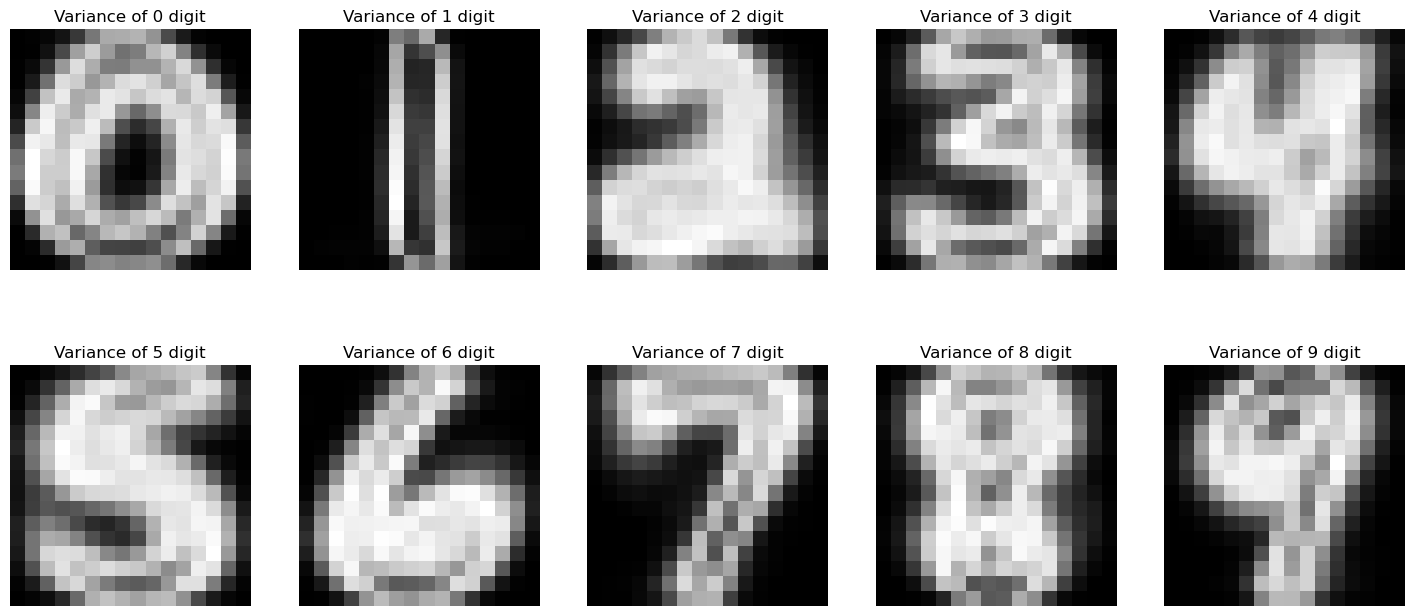

In [7]:
var_digits = np.zeros((10,n_features), dtype=np.float64)
fig = plt.figure(figsize=(18,8))
for i in range(0,10):
    var_digits[i] = digit_variance(X_train, y_train, i)
    fig.add_subplot(2,5,i+1)
    plt.imshow(var_digits[i].reshape(16,16), cmap="gray")
    plt.axis('off')
    plt.title("Variance of {} digit".format(i))

## Gaussian Naive Bayes
Next we implement the Gaussian Naive Bayes Classifier from scratch. The classifier is compatible with scikit-learn and it is build upon its base estimator. The basic intuition of the classifier is the computation the gaussian probability density function of each class, and then the classification of each sample to the class the has the highest probability. Considering the Bayes Theorem, we have:

$$P(y| x_1, ..., x_n)=\frac{P(y)P(x_1,...,x_n|y)}{P(x_1,...,x_n)}
= \frac{P(y) {\prod_{i=1}^{n}P(x_i|y)}}{P(x_1,...,x_n)}$$

$P(y)$ are the a-priori probabilities of each class and are computed as the relative frequency from the train data. Considering that the features (pixels) are statistically independent and they correlate only to their relevant class:
$$P(x_i|y, x_1,...,x_{i-1},x_{i+1},...,x_n) = P(x_i,y)$$
The classification rule goes as:
$$\hat{y} = argmax_yP(y){\prod_{i=1}^{n}P(x_i|y)}$$
Considering
$$P(x_i|y) = \frac{1}{{\sigma_y \sqrt {2\pi } }}e^{{{( {x_i - \mu_y })^2 }{{{{-( {x_i - \mu_y })^2 }{2\sigma_y ^2 }}}} {2\sigma_y ^2 }}} $$
The estimation of each class a given feature is the one that maximizes the above probability. We have to consider that the only parameter of our implementation is the variance of the features. We can use unit variance (equal to 1 for all the classes), and not the variance corresponding to the training data.

In [8]:
class CustomNBClassifier(BaseEstimator, ClassifierMixin):
    """Custom implementation Naive Bayes classifier"""

    def __init__(self, use_unit_variance=False):
        self.use_unit_variance = use_unit_variance
        self.X_mean_ = None
        self.X_var_ = None
        self.apriori = None
        self.classes = None

    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        Calculates self.X_mean_ and self.X_var_ based on the mean feature values in X for each class
        self.X_mean_ becomes a numpy.ndarray of shape(n_classes, n_features)
        self.X_var_ becomes a numpy.ndarray of shape(n_classes, n_features) considering if use_unit_variance is true
        self.apriori_ becomes a numpy.ndarray of shape(n_classes, n_features)
        Calculate the prior posibilities for the classes
        self.apriori becomes numpy.ndarray of shape(n_classes, 1)
        fit always returns self.
        """
        self.classes = np.unique(y)
        self.X_mean_ = np.zeros((len(self.classes), X.shape[1]), dtype = np.float64)
        self.X_var_ = np.zeros((len(self.classes), X.shape[1]), dtype = np.float64)
        for digit in self.classes:
            self.X_mean_[digit] = digit_mean(X, y, digit)
            if not self.use_unit_variance:
                self.X_var_[digit] = digit_variance(X, y, digit)
            else:
                self.X_var_[digit] =1
            
        self.apriori = calculate_priors(X,y)
        return self


    def predict(self, X):
        """
        Make predictions for X based on the
        euclidean distance from self.X_mean_
        """
#         aposteriori = np.asarray([np.prod(pdf(X, self.X_mean_[digit], self.X_var_[digit]),axis=1) \
#                                     for digit in self.classes])
        aposteriori = np.asarray([np.sum(np.log(pdf(X, self.X_mean_[digit], self.X_var_[digit])),axis=1) \
                                    for digit in self.classes])
#         return np.argmax(aposteriori.T*self.apriori, axis=1)
        return np.argmax(aposteriori.T + self.apriori, axis=1)


    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        predicted = self.predict(X)
        return (np.sum(predicted==y))/len(y)

Next we train the classifier using our training data and compute the accuracy of our model using the test data. We have created two models, the first using unit variance and the second without it and the corresponding accuracies on the test data were 0.8137 and 0.7309.

In [9]:
GNB_clf = CustomNBClassifier(use_unit_variance=False)
GNB_clf.fit(X_train, y_train)
GNB_clf_score = GNB_clf.score(X_test, y_test)
print("The accuracy of the GNB classifier using the data variance is {:.4f}".format(GNB_clf_score))

GNB_clf_var = CustomNBClassifier(use_unit_variance=True)
GNB_clf_var.fit(X_train, y_train)
GNB_clf_var_score = GNB_clf_var.score(X_test, y_test)
print("The accuracy of the GNB classifier using unit variance is {:.4f}".format(GNB_clf_var_score))

The accuracy of the GNB classifier using the data variance is 0.7309
The accuracy of the GNB classifier using unit variance is 0.8137


We will compare our classifier with some scikit-learn classifiers like Gaussian Naive Bayes, k-NN and SVM using polynomial kernel. For the training of our models we will use 5-fold Cross Validation. Cross Validation is a resampling method that uses different portions of the data to test and train a model on different iterations, and one wants to estimate the model's accuracy in practice. Next we define the classifiers and the functions used for their training.

In [10]:
def evaluate_classifier(clf, X, y, folds=5):
    """Returns the 5-fold accuracy for classifier clf on X and y
    Args:
        clf (sklearn.base.BaseEstimator): classifier
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
    Returns:
        (float): The 5-fold classification score (accuracy)
    """
    clf_scores = cross_val_score(clf, X, y, cv=folds)
    return clf_scores

knn_classifier = KNeighborsClassifier()
skNB_classifier = GaussianNB()
customNB_classifier = CustomNBClassifier(use_unit_variance=True)
svc_poly = SVC(kernel="poly")

kNNscores = evaluate_classifier(knn_classifier, X_train, y_train, folds=5)
skNBscores = evaluate_classifier(skNB_classifier, X_train, y_train, folds=5)
customNBscores = evaluate_classifier(customNB_classifier, X_train, y_train, folds=5)
svm_scores = evaluate_classifier(svc_poly, X_train, y_train, folds=5)

compare_scores= {
    "knn" : np.mean(kNNscores),
    "scikit GNB" : np.mean(skNBscores),
    "custom GNB" : np.mean(customNBscores),
    "SVM (polynomial kernel)" : np.mean(svm_scores)
}

for key in compare_scores:
    print("The accuracy of "+key+" classifier is {:.5f}".format(compare_scores[key]))

The accuracy of knn classifier is 0.96105
The accuracy of scikit GNB classifier is 0.74859
The accuracy of custom GNB classifier is 0.84899
The accuracy of SVM (polynomial kernel) classifier is 0.97970


We will use ensembling techniques to combine the classifiers with the best accuracy score in order to increase the accuracy of them by comparing those to each other. First we will use the Voting Classifier, which computes the mean value of predictions of all the classifiers involved. From a frequency perspective, the classification error is distributed to the voting classifier considering the tradeoff between voting and variance.

In [11]:
allestimators = [("SVM (polynomial kernel)", svc_poly), ("knn", knn_classifier),("custom GNB", customNB_classifier)]
voting_scores = evaluate_classifier(VotingClassifier(allestimators, voting = 'hard'), X_train, y_train, folds=5)

In [12]:
print("The Voting Classifier using SVM polynomial, kNN, custom Gauss Naive Bayes classifier(5-fold cv) has {:.4f}"\
      "+-{:.5f}".format(np.mean(voting_scores),np.std(voting_scores)))

The Voting Classifier using SVM polynomial, kNN, custom Gauss Naive Bayes classifier(5-fold cv) has 0.9641+-0.00477


Another ensembling technique is Bagging classifier. The difference between Bagging and Voting classifier is that during the training phase, the classifiers are trained in sequence and each classifier is trained using a weighed part of training data and the weight of each feature is relevant to the accuracy of the previous classifiers.

In [13]:
bagging_scores= {
    "knn" : evaluate_classifier(BaggingClassifier(knn_classifier, n_estimators=10, random_state=0), 
                                X_train, y_train, folds=5),
    "custom GNB" : evaluate_classifier(BaggingClassifier(customNB_classifier, n_estimators=10, random_state=0) , 
                                       X_train, y_train, folds=5),
    "SVM (polynomial kernel)" : evaluate_classifier(BaggingClassifier(svc_poly, n_estimators=10, random_state=0), 
                                                    X_train, y_train, folds=5),
}

for key in bagging_scores:
    print("The accuracy for "+key+" classifier is {:.4f}".format(np.mean(bagging_scores[key])))

The accuracy for knn classifier is 0.9616
The accuracy for custom GNB classifier is 0.8490
The accuracy for SVM (polynomial kernel) classifier is 0.9782


### Simple Neural Network
Last, we will develop a neural network model using pytorch and train it with the training data. First, we will use the pytorch Dataset and Dataloader classes in order to develop our own custom dataloader. Moreover, we will use a simple transformer that transform our data from numpy array to pytorch tensor

In [14]:
class OpticalDigitRecognitionDataset(Dataset):
    """OpticalDigitRecognitionDataset."""

    def __init__(self, X, y, transform=None):
        """
        Args:
            X: feature in np.array
            y: labels in np.array
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.n_classes = np.unique(self.y).shape[0]
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        if self.transform:
            return self.transform((self.X[idx], self.y[idx]))
        else:
            return self.X[idx], self.y[idx]

class ToTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, datum):
        x, y = datum[0], datum[1]
        t = torch.from_numpy(x).type(torch.FloatTensor)
        return t, y

We choose 64 as batch size and we create all the necessary dataloaders.

In [15]:
batch_size = 64
to_tensor_trasform = transforms.Compose([ToTensor()])

nn_train_data = OpticalDigitRecognitionDataset(X_train, y_train, transform= to_tensor_trasform)
nn_train_test = OpticalDigitRecognitionDataset(X_test, y_test, transform= to_tensor_trasform)

train_loader = DataLoader(nn_train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(nn_train_test, batch_size=batch_size, shuffle=True, num_workers=4)

Next we define our network's architecture. We will have two layers of 32 and 64 neurons each, and we will use Relu as our activation function. For the output layer we will use the softmax activation function.

In [16]:
class NN3layers(torch.nn.Module):
    
    def __init__(self, n_features, H_1, H_2, n_classes):
        super(NN3layers, self).__init__()
        self.l1 = nn.Linear(n_features, H_1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(H_1, H_2)
        self.l3 = nn.Linear(H_2, n_classes)
        
    def forward(self, x):
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        h = self.l3(h2)
        return F.softmax(h)

We define the simple Deep Neural Network as a scikit-learn classifier. Cross Entropy Loss was chosen as our loss function, Stochastic Gradient Descent as the optimizer with learning rate = 0.02 and momentum = 0.95.

In [17]:
class NN3sklearn(BaseEstimator, ClassifierMixin):

    def __init__(self, n_features, H_1, H_2, n_classes, epochs, batch_size):
        self.n_features = n_features
        self.H_1 = H_1
        self.H_2 = H_2
        self.n_classes = n_classes
        self.criterion = nn.CrossEntropyLoss()
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = NN3layers(n_features = n_features, H_1 = self.H_1, H_2 = self.H_2, n_classes=n_classes)

    def fit(self, X, y):
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.02, momentum = 0.95)
        to_tensor_trasform = transforms.Compose([ToTensor()])
        train_data = OpticalDigitRecognitionDataset(X, y, transform = to_tensor_trasform)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        for epoch in range(self.epochs):
            for i, data in enumerate(train_loader):
                X_batch, y_batch = data
                self.optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch.type(torch.LongTensor))
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X, y):
        to_tensor_trasform = transforms.Compose([ToTensor()])
        test_dataset = OpticalDigitRecognitionDataset(X, y, transform = to_tensor_trasform)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
        self.model.eval() 
        predictions = []
        correct = 0
        ns = 0
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                X_batch, y_batch = data
                out = self.model(X_batch)
                val, y_pred = out.max(1)
                predictions.append(y_pred[0].item())
        return predictions
    
    def score(self, X, y):
        predicted = self.predict(X, y)
        return (np.sum(predicted==y))/y.shape[0]

We initialize our the necessary parameters and our model as well.

In [20]:
n_features = nn_train_data.n_features
n_classes = nn_train_data.n_classes
epochs = 50
H_1 = 32
H_2 = 64

NNsklearnModel = NN3sklearn( n_features=n_features, H_1=H_1, H_2=H_2, n_classes=n_classes, epochs=epochs, batch_size=batch_size)

We train our model for 50 epochs and check it accuracy.

In [21]:
NNsklearnModel.fit(X_train, y_train)
print("The accuracy for the training data is: {0:.4f}".format(NNsklearnModel.score(X_train, y_train)))
print("The accuracy for the testing data is: {0:.4f}".format(NNsklearnModel.score(X_test, y_test)))

The accuracy for the training data is: 0.9875
The accuracy for the testing data is: 0.9278


We achieved accuracy = 0.93 using the Deep Neural Network, which is a greater result comparing it to our Custom Naive Bayes model when its accuracy was about 0.85 even when using unit variance and the baggind ensemble method.

### References

<ol>
  <li>R. O. Duda, P.E. Hart and D.G. Stork, Pattern Classification, Wiley, 2001</li>
  <li>C. M. Bishop, Pattern Recognition and Machine Learning, Springer, 2006</li>
</ol> 
